In [1]:
import torch
import tenseal as ts
import pandas as pd
import random
from time import time

# those are optional and are not necessary for training
import numpy as np
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("./data/myTenYearCHD_n1000.csv", index_col=0)
df.head()


,male,age,cigsPerDay,prevalentStroke,prevalentHyp,totChol,sysBP,heartRate,glucose,TenYearCHD
521,1.057131,-1.116420,0.894010,-0.083918,-0.792487,0.053780,-0.758911,-0.622219,-0.309160,1
737,1.057131,-1.116420,0.894010,-0.083918,-0.792487,-0.312693,-1.083813,-0.869361,-0.216819,1
740,-0.945011,-0.538324,-0.756825,-0.083918,-0.792487,-0.198170,0.012732,-0.045556,-0.247599,1
660,-0.945011,1.311586,-0.756825,-0.083918,1.260588,1.542577,2.368274,-0.045556,0.090987,1
411,1.057131,-0.653943,0.894010,-0.083918,1.260588,0.328635,0.906213,-0.951741,-0.432283,0


In [3]:
train_len = 800

X_trn = torch.tensor(df.iloc[:train_len,:-1].values).float()
Y_trn = torch.tensor(df.iloc[:train_len,-1:].values).float()
X_tst = torch.tensor(df.iloc[train_len:,:-1].values).float()
Y_tst = torch.tensor(df.iloc[train_len:,-1:].values).float()

print(f"X_trn has size: {X_trn.shape}")
print(f"Y_trn has size: {Y_trn.shape}")
print(f"X_tst has size: {X_tst.shape}")
print(f"Y_tst has size: {Y_tst.shape}")



X_trn has size: torch.Size([800, 9])
Y_trn has size: torch.Size([800, 1])
X_tst has size: torch.Size([200, 9])
Y_tst has size: torch.Size([200, 1])


## Training a plain text model

In [4]:
class LR(torch.nn.Module):

    def __init__(self, n_features):
        super(LR, self).__init__()
        self.lr = torch.nn.Linear(n_features, 1)
        
    def forward(self, x):
        out = torch.sigmoid(self.lr(x))
        return out
    

In [5]:
n_features = X_trn.shape[1]
n_epochs = 5

# use Binary Cross Entropy Loss
criterion = torch.nn.BCELoss()

def train_plain(n_epochs, verbose = True):
    model = LR(n_features)
    # use gradient descent with a learning_rate=1
    optim = torch.optim.SGD(model.parameters(), lr=1)
    for i in range(n_epochs):
        optim.zero_grad()
        out = model(X_trn)
        loss = criterion(out, Y_trn)
        if verbose:
            print(f"Loss at epoch {i}: {loss.data}")
        loss.backward()
        optim.step()  
    return model

model00 = train_plain(n_epochs)

out = model00(X_trn)
loss = criterion(out, Y_trn)
print(f"Loss at epoch {n_epochs}: {loss.data}")


Loss at epoch 0: 0.6984182000160217
Loss at epoch 1: 0.6502118110656738
Loss at epoch 2: 0.6276904940605164
Loss at epoch 3: 0.6152324080467224
Loss at epoch 4: 0.6078460216522217
Loss at epoch 5: 0.6032528877258301


In [6]:
from torchmetrics.classification import BinaryAccuracy

accuracy = BinaryAccuracy()

In [7]:
plain_prediction = model00(X_tst)
plain_accuracy = accuracy(plain_prediction,Y_tst)

print(f"Plain model accuracy on test set: {plain_accuracy}")


Plain model accuracy on test set: 0.6700000166893005


## Analysis of encrypted evaluation

In [8]:
class EncryptedLR:
    
    def __init__(self, torch_lr):
        # TenSEAL processes lists and not torch tensors,
        # so we take out the parameters from the PyTorch model
        self.weight = torch_lr.lr.weight.data.tolist()[0].copy()
        self.bias = torch_lr.lr.bias.data.tolist().copy()
        
    def forward(self, enc_x):
        # We don't need to perform sigmoid as this model
        # will only be used for evaluation, and the label
        # can be deduced without applying sigmoid
        if type(enc_x) == ts.tensors.ckksvector.CKKSVector:
            enc_out = enc_x.dot(self.weight) + self.bias
        else:
            enc_out = self.weight.dot(enc_x) + self.bias
        return enc_out
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
        
    ################################################
    ## You can use the functions below to perform ##
    ## the evaluation with an encrypted model     ##
    ################################################
    
    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)
        
    def decrypt(self, context):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()
        

In [12]:
# parameters
param = [4096,8192][0]

if param==4096:
    poly_mod_degree = 4096
    coeff_mod_bit_sizes = [40, 20, 40]
    context = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
    context.global_scale = 2 ** 20
else:
    poly_mod_degree = 8192
    #coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 21, 21, 40]
    coeff_mod_bit_sizes = [60,40,40,60]
    context = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
    #context.global_scale = 2 ** 21
    context.global_scale = 2 ** 40
    
# this key is needed for doing dot-product operations
context.generate_galois_keys()

ts.ckks_vector(context, [1]*(poly_mod_degree//2))


In [10]:
test_len = len(Y_tst)

t_start = time()
enc_X_tst = [ts.ckks_vector(context, x.tolist()) for x in X_tst]
t_end = time()
print(f"Encryption of the test-set took {(t_end - t_start)} seconds")


Encryption of the test-set took 0.4591810703277588 seconds


In [11]:
def predict_evaluate(model, X, Y, verbose = True):
    t0 = time()
    Y_pred_enc = [model(x) for x in X]
    prediction_time = time()-t0
    t0 = time()
    if type(Y_pred_enc[0]) == ts.tensors.ckksvector.CKKSVector:
        Y_pred = torch.tensor([y.decrypt() for y in Y_pred_enc]).sigmoid()
    else:
        Y_pred = torch.tensor(Y_pred_enc)
    decryption_time = time()-t0
    pred_accuracy = accuracy(Y_pred.squeeze(),Y.squeeze())
    if verbose:
        print(f"Prediction time: {prediction_time}")
        print(f"Decryption time: {decryption_time}")
        print(f"Test accuracy: {pred_accuracy}")
    return prediction_time, decryption_time, pred_accuracy.tolist()

predict_evaluate(model00, X_tst, Y_tst)


Prediction time: 0.010122060775756836
Decryption time: 0.00020074844360351562
Test accuracy: 0.6700000166893005


(0.010122060775756836, 0.00020074844360351562, 0.6700000166893005)

In [12]:
model01 = EncryptedLR(model00)

predict_evaluate(model01, enc_X_tst, Y_tst)


Prediction time: 0.467116117477417
Decryption time: 0.03894782066345215
Test accuracy: 0.6499999761581421


(0.467116117477417, 0.03894782066345215, 0.6499999761581421)

In [13]:
model10 = EncryptedLR(model00)
model10.encrypt(context)

predict_evaluate(model10, X_tst, Y_tst)


Prediction time: 0.4238772392272949
Decryption time: 0.04023575782775879
Test accuracy: 0.6499999761581421


(0.4238772392272949, 0.04023575782775879, 0.6499999761581421)

In [14]:
model11 = EncryptedLR(model00)
model11.encrypt(context)

predict_evaluate(model11, enc_X_tst, Y_tst)    


Prediction time: 0.5855145454406738
Decryption time: 0.0380396842956543
Test accuracy: 0.6499999761581421


(0.5855145454406738, 0.0380396842956543, 0.6499999761581421)

## Collect stats for training and evaluation

In [15]:
tst = []

verbose = False

for i in range(100):
    t0 = time()
    enc_X_tst = [ts.ckks_vector(context, x.tolist()) for x in X_tst]
    row = [(time()-t0,)]
    
    model0 = train_plain(n_epochs, verbose)
    row.append(predict_evaluate(model0, X_tst, Y_tst, verbose))

    model1 = EncryptedLR(model0)
    row.append(predict_evaluate(model1, enc_X_tst, Y_tst, verbose))

    model1.encrypt(context)
    row.append(predict_evaluate(model1, X_tst, Y_tst, verbose))

    row.append(predict_evaluate(model1, enc_X_tst, Y_tst, verbose))

    tst.append(np.concatenate(row))
    print(f"Round {i+1} completed in {time()-t0}")

res = pd.DataFrame(tst)
res

Round 1 completed in 1.8783512115478516
Round 2 completed in 1.8673205375671387
Round 3 completed in 1.928560733795166
Round 4 completed in 1.9035897254943848
Round 5 completed in 1.8807871341705322
Round 6 completed in 1.9175550937652588
Round 7 completed in 1.9545836448669434
Round 8 completed in 1.902897596359253
Round 9 completed in 1.9493215084075928
Round 10 completed in 1.890667200088501
Round 11 completed in 1.916747808456421
Round 12 completed in 1.9186363220214844
Round 13 completed in 1.9746394157409668
Round 14 completed in 1.9436595439910889
Round 15 completed in 1.8843262195587158
Round 16 completed in 1.9335861206054688
Round 17 completed in 1.884735107421875
Round 18 completed in 1.9477763175964355
Round 19 completed in 1.8781232833862305
Round 20 completed in 1.8626532554626465
Round 21 completed in 1.9066905975341797
Round 22 completed in 2.0874276161193848
Round 23 completed in 1.971142292022705
Round 24 completed in 1.9306707382202148
Round 25 completed in 1.9149370

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.396406,0.005033,0.000126,0.675,0.461613,0.039900,0.670,0.392968,0.036664,0.665,0.498110,0.038021,0.665
1,0.388855,0.004548,0.000129,0.675,0.467259,0.037749,0.670,0.389941,0.036010,0.675,0.495603,0.038030,0.670
2,0.399415,0.007467,0.000182,0.700,0.481218,0.042627,0.665,0.406059,0.037371,0.670,0.507150,0.037176,0.665
3,0.379892,0.007615,0.000193,0.700,0.461322,0.039402,0.645,0.411302,0.038011,0.645,0.516413,0.039094,0.640
4,0.381588,0.006550,0.000175,0.700,0.460068,0.038985,0.680,0.405612,0.037472,0.680,0.502083,0.038457,0.680
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.386645,0.004797,0.000195,0.695,0.447393,0.037776,0.670,0.389898,0.037317,0.665,0.504083,0.037856,0.665
96,0.374006,0.004530,0.000120,0.695,0.448354,0.037460,0.640,0.414314,0.038298,0.650,0.504833,0.037804,0.640
97,0.382146,0.004797,0.000192,0.655,0.454483,0.038417,0.645,0.401362,0.037543,0.645,0.486654,0.036395,0.645
98,0.361923,0.004517,0.000122,0.675,0.444074,0.037611,0.705,0.386775,0.035425,0.700,0.492200,0.036560,0.695


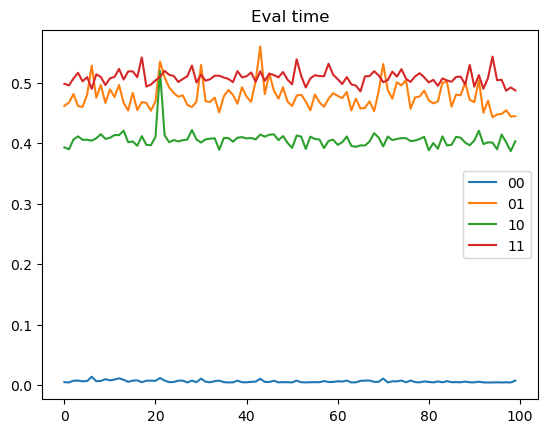

,00,01,10,11
count,100.000000,100.000000,100.000000,100.000000
mean,0.006333,0.477028,0.405797,0.508118
std,0.001884,0.020832,0.013713,0.010794
min,0.004517,0.442913,0.386775,0.485556
25%,0.004856,0.464730,0.400817,0.501481
50%,0.005600,0.474010,0.405974,0.508810
75%,0.007552,0.486020,0.410442,0.512539
max,0.014010,0.559856,0.519136,0.543134


In [16]:
cols = ["00","01","10","11"]
idxs = [1 + 3*i for i in range(4)]
plt.plot(res.iloc[:,idxs])
plt.legend(cols)
plt.title("Eval time")
plt.savefig(f"figs/evaltime_basic_{param}.png")
plt.show()
res.iloc[:,idxs].rename(columns={idx:col for idx,col in zip(idxs,cols)}).describe()


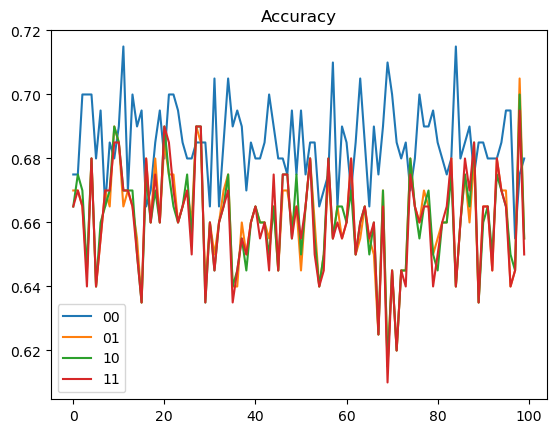

,00,01,10,11
count,100.000000,100.000000,100.000000,100.000000
mean,0.685100,0.660950,0.660850,0.660350
std,0.011913,0.015386,0.015408,0.016116
min,0.655000,0.615000,0.615000,0.610000
25%,0.680000,0.650000,0.650000,0.650000
50%,0.685000,0.660000,0.660000,0.660000
75%,0.695000,0.670000,0.670000,0.670000
max,0.715000,0.705000,0.700000,0.695000


In [17]:
cols = ["00","01","10","11"]
idxs = [3 + 3*i for i in range(4)]
plt.plot(res.iloc[:,idxs])
plt.legend(cols)
plt.title("Accuracy")
plt.savefig(f"figs/accuracy_basic_{param}.png")
plt.show()
res.iloc[:,idxs].rename(columns={idx:col for idx,col in zip(idxs,cols)}).describe()


In [18]:
res.to_csv(f"figs/results_basic_{param}.csv")
